# Finding an Image Within an Image

I've been using PyAutoGUI, and it has a feature where it can locate something on the screen based on an image given to it. I wanted to see if I could make something similar myself, as I had a theory of how it worked. Hence this notebook. I deliberately didn't research the algorithm before I wrote this (I promise) as I wanted to see for myself if my method was correct.

In [24]:
from PIL import Image
import numpy as np
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from matplotlib import patches as pat
plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['figure.figsize'] = (12, 8)

## Get Images

I'll call the image that I'm searching in the "haystack", and the image that I'm looking for the "needle". I made a test image in MS Paint for the "haystack" and cropped out a part to use as the "needle" in this example. I pull the images using PIL, and convert them to numpy arrays (rescaled from 0.0 to 1.0 instead of 0 to 256)

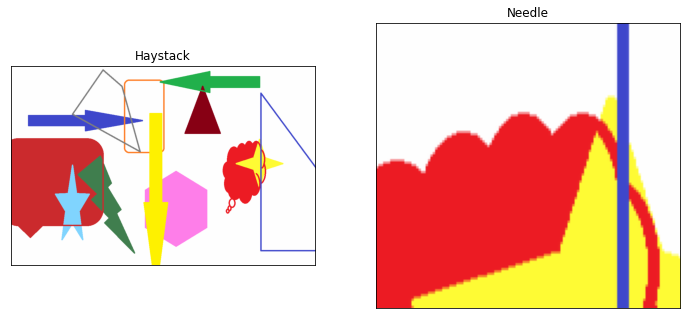

In [27]:
# Get haystack image
haystack = Image.open('data/haystack.png')
haystack = haystack.convert('RGB')
haystack = np.asarray(haystack)
haystack = haystack.astype(np.float32)
haystack /= 256

# Get needle image
needle = Image.open('data/needle.png')
needle = needle.convert('RGB')
needle = np.asarray(needle)
needle = needle.astype(np.float32)
needle /= 256

# Plot images
plt.subplot(121)
plt.imshow(haystack)
plt.title('Haystack')
plt.xticks([])
plt.yticks([])
plt.subplot(122)
plt.imshow(needle)
plt.title('Needle')
plt.xticks([])
plt.yticks([])
plt.show()

## Compute Distance Metric

Here, we scan the needle image over each pixel of the haystack image (kind of like a convolution). However, we are trying to measure how "similar" the neighboring pixels are to the pixels in the needle image. Now, when I hear "similar", I immediately think "distance". In an abstract sense (as far as I understand), distance is a measurement of how "not similar" two things are. It doesn't just apply to locations in space (although, "location" can also be made more abstract)

In this case, I'm treating every possible pixel-centered region as a vector in an N-dimensional space (where N is the number of pixels in the needle image, a rediculously large number). The location of the needle image should be where the corresponding vector is closest to the needle image's vector. In this case, I went with the standard euclidean distance, which means taking the differences between the two vectors in each dimension (pixel), squaring it, and summing all of them together. Since I'm just using this as an error metric, I don't bother taking the square root of the final sum (I do divide by the size of the needle image to normalize it somewhat).

Computing distances:   0%|          | 0/759990 [00:00<?, ?it/s]

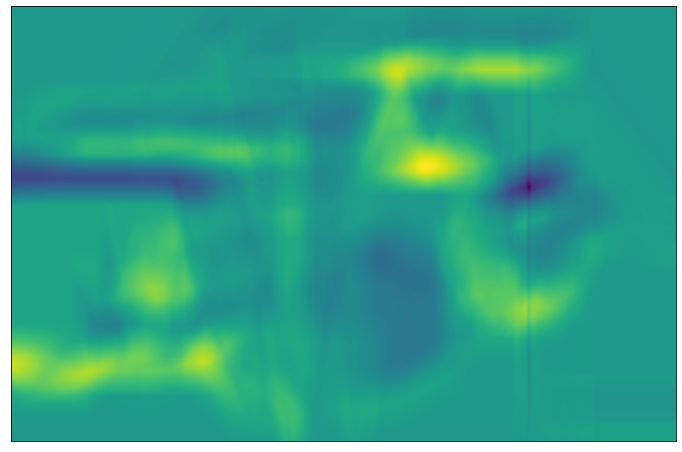

In [28]:
# Set up indeces
hh, hw, _ = haystack.shape
nh, nw, _ = needle.shape
cs = np.gcd(hh, hw)
nx = nw // 2
ny = nh // 2
NJ, NI = np.meshgrid(
    np.arange(0, nw),
    np.arange(0, nh)
)

# Compute distances
distance = np.zeros((hh, hw), dtype=np.float32)
for (i, j) in tqdm(np.ndindex(hh, hw), total=hh*hw, desc='Computing distances'):
    HNi = np.clip(NI + i - nx, 0, hh - 1)
    HNj = np.clip(NJ + j - ny, 0, hw - 1)
    sqdf = (haystack[HNi, HNj, :] - needle[NI, NJ, :])**2
    distance[i,j] = np.sum(sqdf) / needle.size

# Show distances
plt.imshow(distance)
plt.xticks([])
plt.yticks([])
plt.show()

Now it's only a matter of finding the index of the pixel with the minimum distance measurement, which can be done with `argmin`. Once we have that, we can draw a box around where the program thinks the image is using that index.

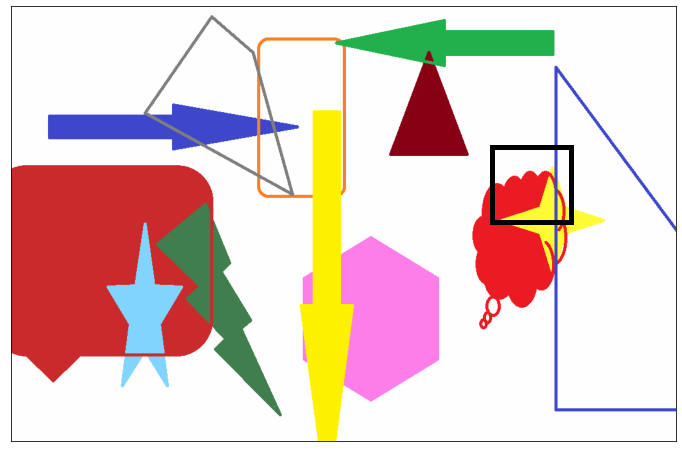

In [31]:
# Compute center of found image from minimum distances
center_index = np.argmin(distance)
cx, cy = np.unravel_index(center_index, distance.shape)
cj = cx - nx
ci = cy - ny

# Show found needle location on plot
patch = pat.Rectangle(
    xy=(ci, cj), 
    width=nw, 
    height=nh, 
    linewidth=5, 
    edgecolor='black', 
    facecolor='none')
fig, ax = plt.subplots()
ax.imshow(haystack)
ax.set_xticks([])
ax.set_yticks([])
ax.add_patch(patch)
plt.show()